In this notebook we will try to implement a simple Machine Learning based strategy to forecast and trade an S&P 500 ETF. <br>
This is a first attempt at implementing a strategy. <br>
The strategy uses a set of very simple technical features, permutation as a feature selection algorithm and an optuna-based hyper parameter optimization. <br>


The strategy is based on the following steps: <br>
    - Defining a target variable: using trend scanner<br>
    - Feature generation<br>
    - Hyperparameter tuning<br>

Ideas for next projects:<br>
    - Grouping of features<br>
    - Rigorous feature selection in walk-forward <br>

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import time
import yfinance as yf
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, make_scorer, roc_curve, 
                             auc, average_precision_score, roc_auc_score, mean_squared_error)

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Settings

In [3]:
settings = {
    'symbol': 'SPY',
    'trend_scanner': {'min': 5, 'max': 30}, # we look for the most signifiant trend between the next 5 and 30 days. Setting minimum value avoids noisy signals
} 

## Data

In [4]:
def get_data(ticker):
    data = ticker.history(period='max')
    return data

In [5]:
ticker = yf.Ticker(settings['symbol'])
df = get_data(ticker)
df.index = pd.to_datetime(df.index).date
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

## Label

In [6]:
def runTrendScanner(prices, min_duration=5):
    """
    Trend Scanner (Numpy Version)
    
    prices is a slice of a numpy array, or Series.values
    min is the minimal trend duration in steps (i.e. days)
    returns most significant t-value
    
    r = [runTrendScanner(df_index['close'][i:i+70].values, min_duration=settings['trend_scanner']['min']) for i in range(len(df_index))]
    
    See MLdP ML for Asset Managers p67 (description)    
    """
    t_value_abs, t_value = 0, -np.inf
    
    for end in range(min_duration, len(prices)):      
        Y = prices[:end]
        X = np.arange(0, end)
        
        X = sm.add_constant(X)
        est = sm.OLS(Y, X).fit()
        
        _t_val = est.tvalues[1]
        
        if abs(_t_val) > t_value_abs:
            t_value_abs = abs(_t_val)
            t_value = _t_val
    
    return t_value

In [7]:
r = [runTrendScanner(df['Close'][i:i+settings['trend_scanner']['max']].values, min_duration=settings['trend_scanner']['min']) for i in range(len(df))]

In [8]:
df_tmp = pd.DataFrame(r, columns=['t_value'], index = df.index)
df_tmp.replace([np.inf, -np.inf], np.nan, inplace=True)


### Plot learning variable

In [9]:
label2color = {
    1: 'green',
    -1: 'red',
    0: 'blue'}

def gen_repeating(s):
    i = 0
    while i < len(s):
        j = i
        while j < len(s) and s[j] == s[i]:
            j += 1

        yield (s[i], i, j - 1)
        i = j

In [10]:
def plotTrendScanning():
    df['color'] = df['side'].apply(lambda label: label2color[label])

    fig, ax = plt.subplots(nrows = 2, figsize = (12,6))
    
    for color, start, end in gen_repeating(df['color']):
        if start > 0:
            start -= 1
        idx = df.index[start:end + 1]
        ax[0].plot(df.loc[idx, 'date'], df.loc[idx, 'Close'], linewidth=1, color=color)

    ax[0].grid(True)
    df.side.value_counts()
        
    tsmin = settings['trend_scanner']['min']
    tsmax = settings['trend_scanner']['max']
    symbol = settings['symbol']
    
    figtitle = f'Trend Scanning for {symbol} between {tsmin} and {tsmax} days'
    ax[0].set_title(figtitle)
    ax[1].plot(df_tmp.index, df_tmp['t_value'])
    ax[1].set_title('Trend Scanner')


In [11]:
df['t_value_abs'] = abs(df_tmp['t_value'])
df['t_value'] = df_tmp['t_value']
df['date'] = df.index

df['side'] = np.nan
tau = 0
df.loc[df.t_value >=  tau, 'side'] = 1
df.loc[df.t_value < -tau, 'side'] = -1
df.dropna(axis=0, inplace=True)

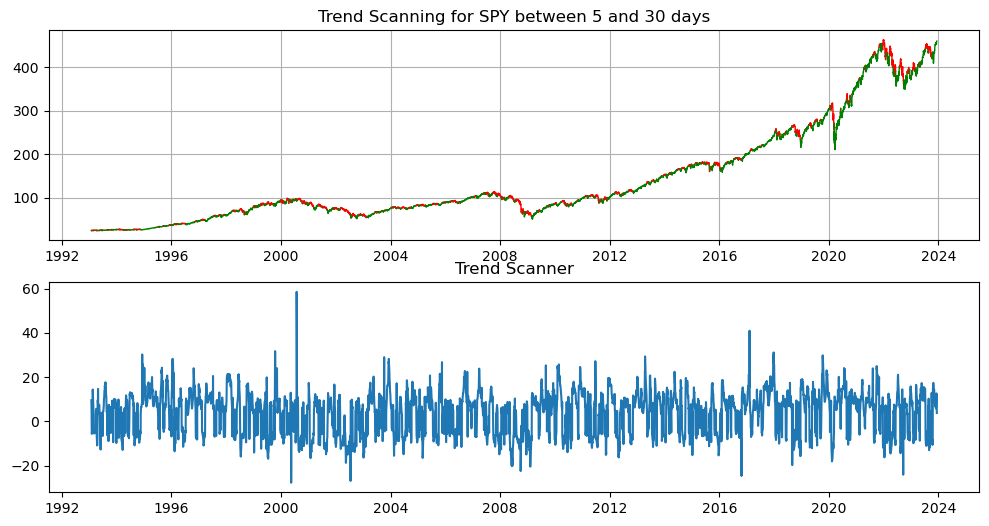

In [12]:
plotTrendScanning()

## Features

In [13]:
lookbacks = [5, 10, 20, 30, 60, 90, 120, 150, 180, 210, 240]

In [14]:
def volatility(lookback):
    log_ret = np.log(df['Close']).diff()
    vol = log_ret.ewm(span=lookback).std() * np.sqrt(252)
    return vol.rename(f'vol_{lookback}', inplace=True)

def sharpe(lookback):
    sr = df['Close'].pct_change().rolling(lookback).mean() / volatility(lookback)
    return sr.rename(f'sr_{lookback}', inplace=True)

def rsi(lookback):
    rrsi = 100 - 100 / (1 + df['Close'].pct_change().rolling(lookback).apply(lambda x: x[x > 0].mean() / -x[x < 0].mean()))
    return rrsi.rename(f'rsi_{lookback}', inplace=True)

def momentum(lookback):
    mom = df['Close'].pct_change(lookback)
    return mom.rename(f'mom_{lookback}', inplace=True)

def trend(lookback):
    ttrend = df['Close'].pct_change().rolling(lookback).apply(lambda x: x[x > 0].sum() / len(x))
    return ttrend.rename(f'trend_{lookback}', inplace=True)

def dist_ma(lookback):
    dma = df['Close']/(df['Close'].rolling(window=lookback).mean())-1
    
def auto_correlation(lookback):
    log_ret = np.log(df['Close']).diff()
    ac = log_ret.rolling(window=lookback, min_periods=1, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
    return ac.rename(f'ac_{lookback}', inplace=True)

def cum_prod(lookback):
    log_ret = np.log(df['Close']).diff()
    cp = np.exp(np.log(log_ret+1).rolling(lookback).sum())-1
    return cp.rename(f'cp_{lookback}', inplace=True)
    
def talib_features():
    import talib
    df_talib = pd.DataFrame()
    df_talib['feat_RSI'] = talib.RSI(df.Close, timeperiod=14)

    df_talib['feat_HT_DCPERIOD'] = talib.HT_DCPERIOD(df.Close)
    df_talib['feat_HT_DCPHASE'] = talib.HT_DCPHASE(df.Close)
    df_talib['feat_MACD'] =  talib.MACD(df.Close, fastperiod=12, slowperiod=26, signalperiod=9)[0]
    df_talib['feat_ROC'] =  talib.ROC(df.Close, timeperiod=10)
    df_talib['feat_PPO'] = talib.PPO(df.Close, fastperiod=12, slowperiod=26, matype=0)
    
    if 'Volume' in index_fields:
        df_talib['feat_OBV'] = talib.OBV(df.Close, df.Volume)
    
    if 'High' in index_fields and 'Low' in index_fields:
        df_talib['feat_stochk'] = talib.STOCHF(df.High, df.Low, df.Close, 
                                            fastk_period=5, fastd_period=3, fastd_matype=0)[0]
        df_talib['feat_stochd'] = talib.STOCHF(df.High, df.Low, df.Close, 
                                            fastk_period=5, fastd_period=3, fastd_matype=0)[1]
        df_talib['feat_stochrsik'] = talib.STOCHRSI(df.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)[0]
        df_talib['feat_stochrsid'] = talib.STOCHRSI(df.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)[1]

        df_talib['feat_ADX'] = talib.ADX(df.High, df.Low, df.Close, timeperiod=14)
        df_talib['feat_ATR'] = talib.ATR(df.High, df.Low, df.Close, timeperiod=14)
        df_talib['feat_CCI'] = talib.CCI(df.High, df.Low, df.Close, timeperiod=14)
        df_talib['feat_WILLR'] = talib.WILLR(df.High, df.Low, df.Close, timeperiod=14)
        
    return df_talib

def all_features(lookback):
    df_feat = pd.DataFrame()
    df_feat = pd.concat([volatility(lookback), 
                         sharpe(lookback),
                         rsi(lookback),
                         momentum(lookback),
                         trend(lookback),
                         dist_ma(lookback),
                         auto_correlation(lookback),
                         cum_prod(lookback)
                         ], 
                        axis=1)
    return df_feat

In [15]:
df_features = pd.DataFrame(index=df.index)

for lookback in lookbacks:
    df_features = pd.concat([df_features, all_features(lookback)], axis=1)

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\vwste\anacond

In [16]:
import_talib_features = False
if import_talib_features:
    talib_features = talib_features()
    df_features = pd.concat([df_features, talib_features], axis=1)

In [17]:
df_features = df_features.shift(1) # we shift the features by one day to avoid look-ahead bias
df_features = df_features.dropna(axis=0)

In [18]:
from sklearn.metrics import log_loss, accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, roc_curve, roc_auc_score, auc, matthews_corrcoef
def evaluate(model, X, y, method, sample_weight=None, labels=None, pos_idx=None):
    """
    Calculate score
    
    Params
    ------
    model: Trained classifier instance
    X: array-like, Input feature
    y: array-like, Label
    method: str
        The name of scoring methods. 'precision', 'recall', 'f1', 'precision_recall',
        'roc', 'accuracy' or 'neg_log_loss'
    labels: array-like, optional
        The name of labels
        
    Returns
    -------
    list of scores
    """
    
    if pos_idx is not None:
        pos_idx = np.where(np.array(labels) == 1)[0][0]
    
    if method == 'f1':
        pred = model.predict(X)
        score = f1_score(y, pred, sample_weight=sample_weight, labels=labels)

    elif method == 'neg_log_loss':
        prob = model.predict_proba(X)
        score = -log_loss(y, prob, sample_weight=sample_weight, labels=labels)

    elif method == 'precision':
        pred = model.predict(X)
        score = precision_score(y, pred, sample_weight=sample_weight)
    
    elif method == 'recall':
        pred = model.predict(X)
        score = recall_score(y, pred, sample_weight=sample_weight)
    
    elif method == 'precision_recall':
        prob = model.predict_proba(X)[:, pos_idx]
        score = precision_recall_curve(y, prob, sample_weight=sample_weight)
    
    elif method == 'roc':
        prob = model.predict_proba(X)[:, pos_idx]
        score = roc_curve(y, prob, sample_weight=sample_weight)
    
    elif method == 'roc_auc_score':
        prob = model.predict_proba(X)[:, 1]
        score = roc_auc_score(y, prob, sample_weight=sample_weight)
    
    elif method == 'accuracy':
        pred = model.predict(X)
        score = accuracy_score(y, pred, sample_weight=sample_weight)
    
    else:
        raise Exception(f'No Implementation method={method}')
    
    return score

In [19]:
"""Permutation importance for estimators"""
# Adapted from scikit-learn permutation importance

from joblib import Parallel
from joblib import delayed

from sklearn.utils import check_random_state
from sklearn.utils import check_array

def _calculate_permutation_scores(estimator, X, y, sample_weight, col_idx, random_state,
                                  n_repeats, scorer):
    """Calculate score when `col_idx` is permuted."""
    random_state = check_random_state(random_state)
    
    #print(col_idx)

    X_permuted = X.copy()
    scores = np.zeros(n_repeats)
    shuffling_idx = np.arange(X.shape[0])
    for n_round in range(n_repeats):
        random_state.shuffle(shuffling_idx)
        if hasattr(X_permuted, "iloc"):
            col = X_permuted.iloc[shuffling_idx, col_idx]
            col.index = X_permuted.index
            X_permuted.iloc[:, col_idx] = col
        else:
            X_permuted[:, col_idx] = X_permuted[shuffling_idx, col_idx]
        feature_score = evaluate(estimator, X_permuted, y, scorer, sample_weight)
        scores[n_round] = feature_score

    return scores

def permutation_importance(clf, X, y, i, train, test, scoring=None, n_repeats=5,
                           n_jobs=None, random_state=None):
    print(f'Permutation Importance Fold {i}')
        
    if not hasattr(X, "iloc"):
        X = check_array(X, force_all_finite='allow-nan', dtype=None)
        
    X0,y0=X.iloc[train,:],y.iloc[train]
    X1,y1=X.iloc[test,:],y.iloc[test]
    w0,w1 = None, None
    
    estimator = clf.fit(X0, y0)

    random_state = check_random_state(random_state)
    random_seed = random_state.randint(np.iinfo(np.int32).max + 1)
       
    baseline_score = evaluate(estimator, X1, y1, scoring)
    
    scores = Parallel(n_jobs=n_jobs)(delayed(_calculate_permutation_scores)(
        estimator, X1, y1, w1, col_idx, random_seed, n_repeats, scoring
    ) for col_idx in range(X.shape[1]))
   
    scr1 = np.mean(scores,axis=1)
    scr0 = baseline_score
    del scores
    return i, scr0, scr1

In [20]:
## Initial test
# create test and validation set for feature selection
from sklearn.model_selection import train_test_split

y = df['side']
X = df_features.copy()
X = X[y.first_valid_index():y.last_valid_index()]
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Hyperoptimization using Optuna

In [21]:
from sklearn.model_selection import TimeSeriesSplit
def objective(trial, X, y, n_splits=5):

    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9, step=0.1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 0.8, step=0.1),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 0.9, step=0.1),
    }
    
    cv = TimeSeriesSplit(n_splits=n_splits, test_size=66)

    cv_scores = np.empty(n_splits)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = lgb.LGBMClassifier(objective="binary",verbose=-1, **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
        )
        
        preds = model.predict(X_test)
        cv_scores[idx] = accuracy_score(y_test, preds)

    return np.median(cv_scores)

In [23]:
import optuna

In [24]:
n_splits = 5 
direction = 'maximize'
study_name = 'LGBM'
sampler = optuna.samplers.TPESampler(seed=24)
study = optuna.create_study(direction=direction, study_name=study_name, sampler=sampler)
func = lambda trial: objective(trial, X_train, y_train, n_splits)

[I 2023-12-19 12:09:34,879] A new study created in memory with name: LGBM


In [25]:
study.optimize(func, n_trials=100) #non-parallel

c:\Users\vwste\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\vwste\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\vwste\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\vwste\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\vwste\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

In [26]:
optuna.visualization.plot_parallel_coordinate(study)

In [27]:
best_params = study.best_params
best_params

{'n_estimators': 600,
 'learning_rate': 0.3855938611994342,
 'max_depth': 7,
 'subsample': 0.5,
 'bagging_fraction': 0.7,
 'feature_fraction': 0.7}

In [28]:
scoring='roc_auc_score'
n_repeat=5
cv = 5
cvGen = KFold(n_splits=cv)
clf = lgb.LGBMClassifier(verbose=-1 , **best_params)

In [29]:
results = []
for i,(train,test) in enumerate(cvGen.split(X=X_train)):
    res = permutation_importance(clf, X, y, i, train, test, scoring=scoring, n_repeats=n_repeat,
                                 n_jobs=None, random_state=None)
    results.append(res)

Permutation Importance Fold 0
Permutation Importance Fold 1
Permutation Importance Fold 2
Permutation Importance Fold 3
Permutation Importance Fold 4


In [30]:
def importance(permuation_results, scoring='neg_log_loss'):
    scr0 = pd.Series([j[1] for j in results])
    scr1 = pd.DataFrame([j[2] for j in results], columns = X.columns)
    imp=(-scr1).add(scr0,axis=0)
    
    if scoring == 'neg_log_loss':
        imp = imp / -scr1
    else:
        imp=imp/(1.-scr1)

    imp = imp.replace({0.0:np.nan})
    imp_df=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5, 'median':imp.median()},axis=1)
    imp = {'df': imp_df, 'all': imp}
    
    return imp

In [31]:
def plotMDA(imp):
    fig = plt.figure()
    
    mda_threshold = 0
    imp = imp.sort_values('mean', ascending=True)
    i = 0
    
    for r in imp.iterrows():
        data = r[1][:-2]
        data_mean = r[1]['mean']
        data_median = r[1]['median']
        plt.scatter(data, [i] * len(data), marker='|', color='black')
        plt.scatter(data_mean, i, marker='.', color='red' if data_mean < 0 else 'green')
        i = i + 1
        
    plt.axvline(mda_threshold, color='gray')
    plt.show()

In [32]:
imp = importance(results, scoring=scoring)
imp['df'].sort_values('mean', ascending=False)

,mean,std,median
ac_180,0.010873,0.003723,0.012425
sr_30,0.008622,0.001904,0.008243
mom_210,0.007926,0.004769,0.009974
rsi_20,0.007652,0.001786,0.007518
rsi_150,0.006383,0.004575,0.004597
...,...,...,...
ac_120,-0.010185,0.012144,0.004657
trend_180,-0.010726,0.008827,-0.004578
trend_150,-0.013891,0.006768,-0.012765
rsi_120,-0.016104,0.007199,-0.012946


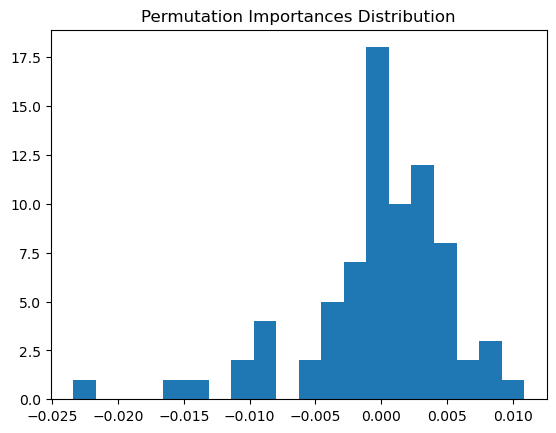

In [33]:
plt.hist(imp['df']['mean'], bins=20)
plt.title('Permutation Importances Distribution')
plt.show()

In [34]:
from scipy import stats
stats.probplot(imp['df']['mean'])
plt.show()

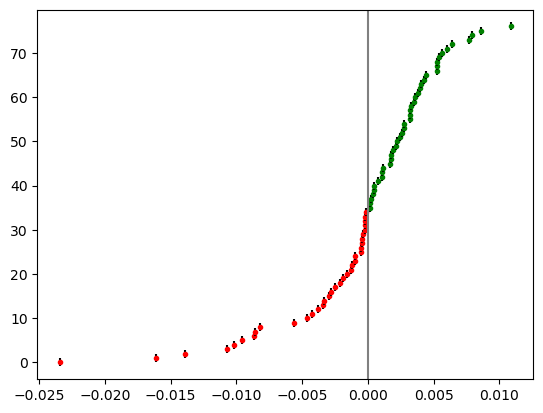

In [35]:
plotMDA(imp['df'])

In [36]:
imp['df'].sort_values('mean', ascending=True)

,mean,std,median
trend_120,-0.023412,0.017939,-0.008984
rsi_120,-0.016104,0.007199,-0.012946
trend_150,-0.013891,0.006768,-0.012765
trend_180,-0.010726,0.008827,-0.004578
ac_120,-0.010185,0.012144,0.004657
...,...,...,...
rsi_150,0.006383,0.004575,0.004597
rsi_20,0.007652,0.001786,0.007518
mom_210,0.007926,0.004769,0.009974
sr_30,0.008622,0.001904,0.008243


In [37]:
filtered_features = imp['df'][imp['df']['mean'] > 0].index
filtered_features

Index(['vol_5', 'sr_5', 'vol_10', 'rsi_10', 'mom_10', 'ac_10', 'cp_10',
       'vol_20', 'sr_20', 'rsi_20', 'mom_20', 'ac_20', 'vol_30', 'sr_30',
       'trend_30', 'cp_30', 'vol_60', 'sr_60', 'mom_60', 'ac_60', 'cp_60',
       'vol_90', 'mom_90', 'cp_90', 'vol_120', 'sr_120', 'vol_150', 'sr_150',
       'rsi_150', 'ac_150', 'vol_180', 'ac_180', 'vol_210', 'sr_210',
       'mom_210', 'trend_210', 'cp_210', 'vol_240', 'sr_240', 'mom_240',
       'trend_240', 'cp_240'],
      dtype='object')

In [38]:
# Evaluate
from sklearn import metrics

def matrix_eval(clf, X_train, y_train, y_test, X_test, features = False):
    
    if features:
        print(f'Features: {features}')
        X_train = X_train[filtered_features]
        X_test = X_test[filtered_features]
        
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    
    return fpr, tpr, auc, y_pred_proba

Features: True


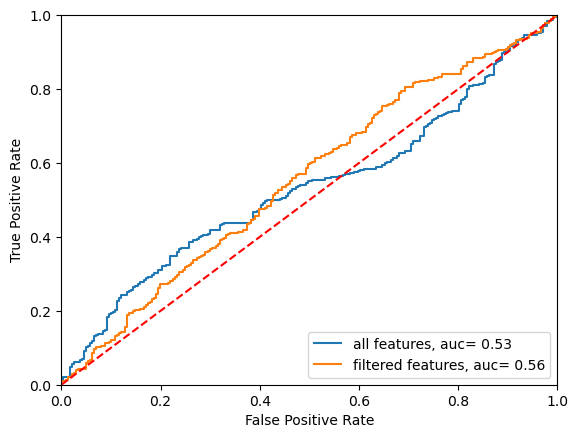

In [39]:
clf = lgb.LGBMClassifier(verbose=-1, **best_params)

fig, ax = plt.subplots()
for name, feats in zip(['all', 'filtered'], [False, True]):
    fpr, tpr, auc, y_pred_proba = matrix_eval(clf, X_train, y_train, y_test, X_test, feats)
    ax.plot(fpr,tpr,label=f"{name} features, auc= {auc:.2f}")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [40]:
df_plot = df[['Close', 'side']].copy()
df_plot = df_plot.loc[y_test.index]
df_plot['pred'] = pd.Series((y_pred_proba-0.5)*2, index= y_test.index)

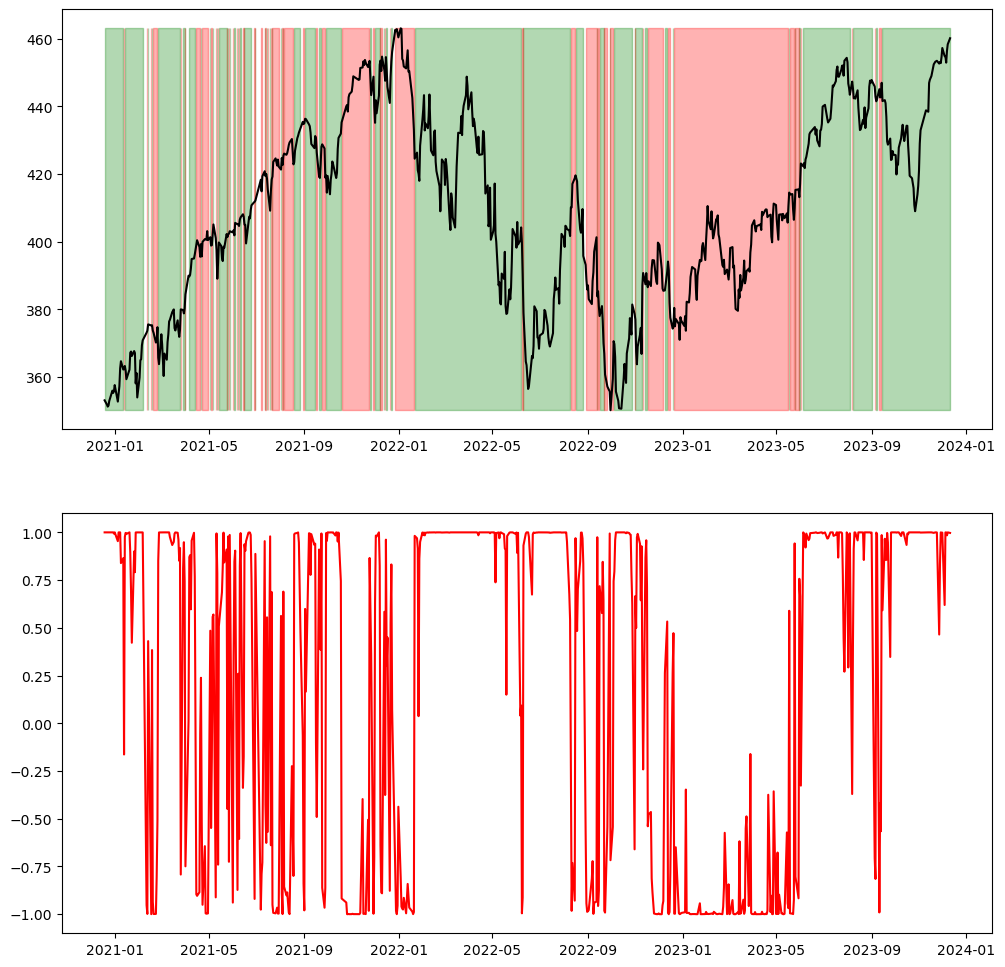

In [41]:
fig, ax = plt.subplots(nrows=2, figsize=(12,12))
ax[0].plot(df_plot['Close'], color='black')
ax[0].fill_between(df_plot.index, df_plot['Close'].min(), df_plot['Close'].max(),where=df_plot['pred']>0, color='green', alpha=0.3)
ax[0].fill_between(df_plot.index, df_plot['Close'].min(), df_plot['Close'].max(),where=df_plot['pred']<0, color='red', alpha=0.3)
ax[1].plot(df_plot['pred'], color='red')